## Training and testing CNN MobileNet v3 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from mobilenetv3 import mobilenetv3_large, mobilenetv3_small
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [ ]:
def count_mean_std(data_folder):
    '''
    Функция подсчитывает усредненные значения mean и std по всему датасету и возвращает их
    '''
    data = dset.ImageFolder(
        root=data_folder,
        transform = transforms.ToTensor())
    
    dataiter = iter(data)
    
    count = 0
    for i in dataiter:
        features, _ = i
        if not count:
            mean_sum = features.mean(axis=(1,2))
            std_sum = features.std(axis=(1,2))
        else:
            mean_sum += features.mean(axis=(1,2))
            std_sum += features.std(axis=(1,2))
        count += 1

    mean_value = mean_sum / count
    std_value = std_sum / count
    
    return (mean_value, std_value)

def load_dataset(data_folder, batch_size):
    '''
    Функция импортирует данные из указанной директории и возвращает DataLoader объекты
    '''
    mean_value = [0.6007, 0.5609, 0.6516]
    std_value = [0.0821, 0.0864, 0.0670]
    
    if not (mean_value and std_value):
        mean_value, std_value = count_mean_std(data_folder)
    
    data = dset.ImageFolder(
        root=data_folder,
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_value, std=std_value)
        ])
    )
    
    test_split = 0.2
    val_split = 0.2
    test_split_ind = int(np.floor(test_split * len(data.imgs)))
    val_split_ind = test_split_ind + int(np.floor(val_split * (len(data.imgs) - test_split_ind)))
    indices = list(range(len(data.imgs)))
    np.random.shuffle(indices)
    
    test_indices, val_indices, train_indices = indices[:test_split_ind], indices[test_split_ind:val_split_ind], indices[val_split_ind:]                  
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    
    train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

batch_size = 64
train_loader, val_loader, test_loader = load_dataset('./data/', batch_size)

In [ ]:
nn_model = mobilenetv3_large(num_classes=5)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using Adam optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,
                scheduler = StepLR(optimizer, step_size = 1, gamma = 1.0)):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        print('current epoch is ', epoch)
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            print('current step is ', i_step)
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, 1) # 1 stands for the dimention to reduce (read more in the documentation)
            correct_samples += torch.sum(indices == y) # using equation is suitable, because index and label are coincided
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i, (x, y) in enumerate(loader):
        print('current val step is ', i)
        prediction = model(x)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
        
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20)

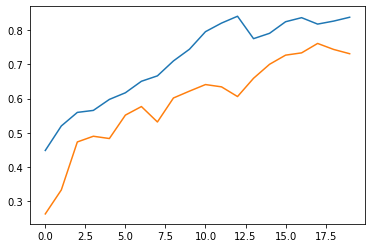

In [8]:
plt.plot(train_history)
plt.plot(val_history);

In [ ]:
test_accuracy = compute_accuracy(nn_model, test_loader)
test_accuracy